# Определение возраста покупателей

## Подготовка

**Описание:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


In [1]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd 
import matplotlib.pyplot as plt

## Исследовательский анализ данных

In [3]:
labels_data = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels_data.sample(5)

,file_name,real_age
5746,005746.jpg,74
4029,004029.jpg,58
6372,006376.jpg,73
1842,001842.jpg,60
994,000994.jpg,40


Посмотрим на распределение возраста в датасете

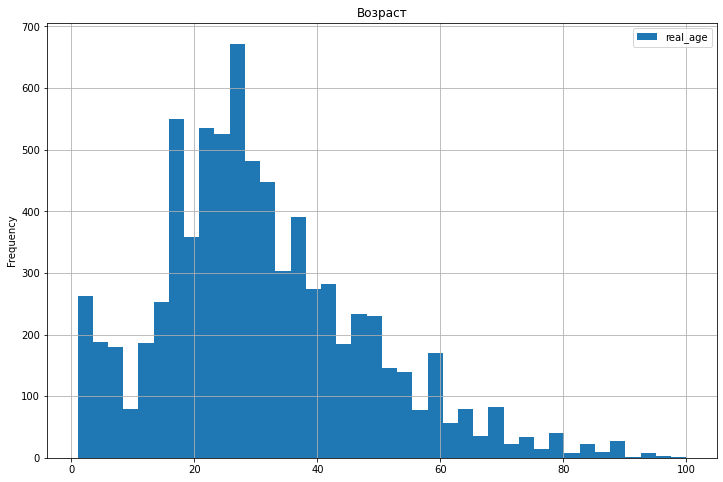

In [6]:
labels_data.plot(kind='hist', bins=40, y='real_age',grid=True, title='Возраст', figsize=(12,8));

In [7]:
labels_data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Данные выглядят правдоподобно и близки к нормальному распределению.

Взгляним на фотографии

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=137)

Found 7591 validated image filenames.


Возраст человека на фото: 31


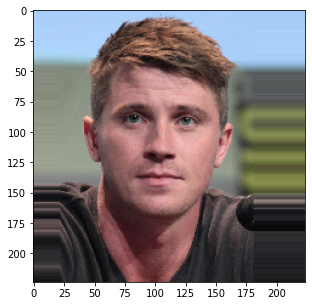

Возраст человека на фото: 15


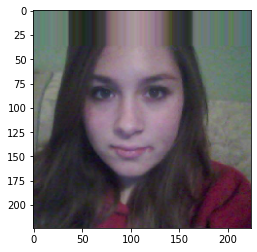

Возраст человека на фото: 57


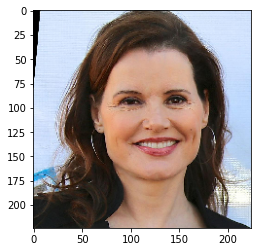

Возраст человека на фото: 23


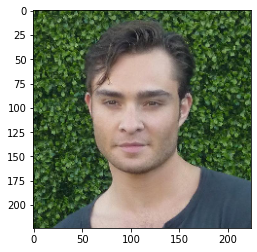

Возраст человека на фото: 16


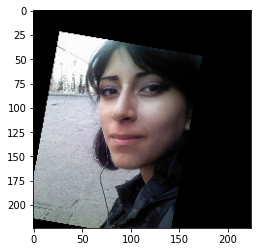

Возраст человека на фото: 26


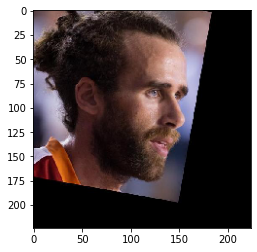

Возраст человека на фото: 30


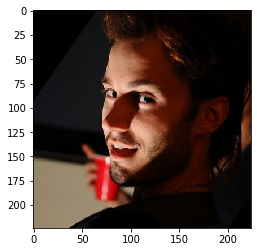

Возраст человека на фото: 43


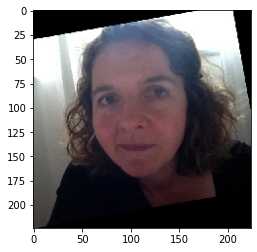

Возраст человека на фото: 11


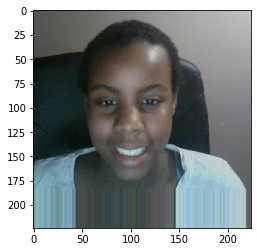

In [10]:
features, target  = next(train_gen_flow)

plt.figure(figsize=(5, 5))

for i in range(1,10):
    plt.imshow(features[i])
    print(f'Возраст человека на фото: {target[i]}')
    plt.show()

Как можно видеть на первый взгляд возраст на фото проставлен довольно-таки правоподобно, но что касается самих фотографий у некоторых качество оставляет желать лучшего, на каких-то прикрыто лицо рукой или каким-то предметом, есть фото где лицо закрыто полностью и вообще все фотографии довольно-таки разнородные, все эти факторы отрицательно скажуться на обучении нейросети.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import pandas as pd




def load_train(path):
    labels_age_data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True,  validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_age_data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        subset='training',
        class_mode='raw',
        seed=0
    )
    return train_gen_flow


def load_test(path):
    labels_age_data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)
    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_age_data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        class_mode='raw',
        seed=0
    )
    return test_gen_flow

    
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
178/178 - 76s - loss: 227.0062 - mae: 10.7340 - val_loss: 948.0737 - val_mae: 25.9828
Epoch 2/10
178/178 - 40s - loss: 75.9079 - mae: 6.5531 - val_loss: 839.5826 - val_mae: 24.0144
Epoch 3/10
178/178 - 40s - loss: 51.7291 - mae: 5.4490 - val_loss: 355.2442 - val_mae: 14.0155
Epoch 4/10
178/178 - 40s - loss: 36.1733 - mae: 4.6386 - val_loss: 160.0754 - val_mae: 9.2868
Epoch 5/10
178/178 - 40s - loss: 27.2285 - mae: 3.9635 - val_loss: 74.6577 - val_mae: 6.5135
Epoch 6/10
178/178 - 46s - loss: 22.3493 - mae: 3.6300 - val_loss: 66.5288 - val_mae: 6.0564
Epoch 7/10
178/178 - 46s - loss: 18.6005 - mae: 3.3206 - val_loss: 67.2085 - val_mae: 6.2107
Epoch 8/10
178/178 - 44s - loss: 16.5282 - mae: 3.1085 - val_loss: 67.7921 - val_mae: 6.2244
Epoch 9/10
178/178 - 46s - loss: 15.7851 - mae: 2.9943 - val_loss: 81.1924 - val_mae: 6.7124
Epoch 10/10
178/178 - 45s - loss: 12.2088 - mae: 2.6826 - val_loss: 75.0295 - val_mae: 6.3857
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 75.0295 - mae: 6.3857
Test MAE: 6.3857
```

## Анализ обученной модели

Не смотря, на выше перечисленные недостатки базы данных, нейросеть достаточно хорошо справилась, MAE = 6.3, хотя было использованно 10 эпох и горизонтальный поворот фотографий, при настройке сети на 5 эпох, лучший результат был MAE = 6.9, но в выводе мы видим что лучший результат был достигнут на 6й эпохе. Если применить код (пример внизу) то обучение можно остановить достигнув желаймых показателей. Но в принципе сеть справилась с задачей и по нагрузке на сервер, времени обучения и результатам, считаю ее оптимальной. 

```python
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True
        
```

Что косаетсья бизнеса, я думаю что модель от части решает задачи бизнеса, предложение актуальных товаров, по моему мнению задача странная, в прикассовой зоне анализировать возраст и предлогать товар? когда весь ассортимент товаров за спиной у покупателя, в прикассовой зоне очень ограниченный ассортимент товара который можно предложить, скорее лучше анализировать при в ходе непосредственно в магазин, что относиться к добросовестности кассиров с этой задачей модель справиться гораздо лучше относительно первой, но тоже необходимо брать во внимание что модель может ошибаться.